In [1]:
# Y-Topology Aware Distance Binning
# Separates A-line branches with buffer zones to prevent false kernel correlations

import pandas as pd
import numpy as np
from scipy.ndimage import median_filter
from scipy import interpolate
import matplotlib.pyplot as plt

# ============================================================
# CONSTANTS
# ============================================================

# Input files
STATION_MAP_FILE = "../data/a_line_station_distances.csv"
ARRIVALS_FILE = "../data/nyc_subway_a_line_arrivals_2025.csv"

# Output files
OUTPUT_HEADWAY_FILE = "../data/headway_matrix_topology.npy"
OUTPUT_SCHEDULE_FILE = "../data/schedule_matrix_topology.npy"
OUTPUT_GRID_FILE = "../data/topology_grid.csv"

# Binning parameters
DISTANCE_BIN_MI = 0.5  # Same as distance-based binning
TIME_BIN_SIZE_MIN = 1  # 1-minute resolution
BUFFER_SIZE = 3        # 3 zero-bins between branches (blocks 3x1 kernel)

print("Y-Topology Binning Configuration:")
print(f"  Distance bin size: {DISTANCE_BIN_MI} mi")
print(f"  Time resolution: {TIME_BIN_SIZE_MIN} min")
print(f"  Buffer size: {BUFFER_SIZE} bins")

Y-Topology Binning Configuration:
  Distance bin size: 0.5 mi
  Time resolution: 1 min
  Buffer size: 3 bins


In [2]:
# 1. Load Station Data and Define Branch Membership

station_map = pd.read_csv(STATION_MAP_FILE)
all_stations = station_map[station_map['location_type'] == 1][
    ['stop_id', 'stop_name', 'distance_from_start_mi']
].drop_duplicates().sort_values('distance_from_start_mi').reset_index(drop=True)

print(f"Total stations: {len(all_stations)}")

# Define branch membership
LEFFERTS_IDS = ['A63', 'A64', 'A65']  # 104 St, 111 St, Ozone Park-Lefferts Blvd
ROCKAWAY_IDS = [s for s in all_stations['stop_id'] if s.startswith('H')]  # All H-prefix
TRUNK_IDS = [s for s in all_stations['stop_id'] 
             if s.startswith('A') and s not in LEFFERTS_IDS]

# Create branch dataframes
trunk_stations = all_stations[all_stations['stop_id'].isin(TRUNK_IDS)].copy()
lefferts_stations = all_stations[all_stations['stop_id'].isin(LEFFERTS_IDS)].copy()
rockaway_stations = all_stations[all_stations['stop_id'].isin(ROCKAWAY_IDS)].copy()

print(f"\nBranch breakdown:")
print(f"  Trunk (Inwood → Rockaway Blvd): {len(trunk_stations)} stations")
print(f"  Lefferts branch: {len(lefferts_stations)} stations")
print(f"  Rockaway branch: {len(rockaway_stations)} stations")

# Verify we have all stations
assert len(trunk_stations) + len(lefferts_stations) + len(rockaway_stations) == len(all_stations)

Total stations: 66

Branch breakdown:
  Trunk (Inwood → Rockaway Blvd): 49 stations
  Lefferts branch: 3 stations
  Rockaway branch: 14 stations


In [3]:
# 2. Create Separate Distance Grids for Each Branch

# Branch point is Rockaway Blvd (A61) - all branches diverge from here
BRANCH_POINT_DIST = trunk_stations[trunk_stations['stop_id'] == 'A61']['distance_from_start_mi'].values[0]
print(f"Branch point (Rockaway Blvd): {BRANCH_POINT_DIST:.2f} mi")

# TRUNK: Rockaway Blvd (9.69 mi) → Inwood (32.20 mi)
# We keep original distances, sorted ascending (south to north)
trunk_min = trunk_stations['distance_from_start_mi'].min()
trunk_max = trunk_stations['distance_from_start_mi'].max()
trunk_grid = np.arange(trunk_min, trunk_max + DISTANCE_BIN_MI, DISTANCE_BIN_MI)
print(f"\nTrunk grid: {trunk_min:.2f} - {trunk_max:.2f} mi ({len(trunk_grid)} bins)")

# LEFFERTS: Short branch, 3 stations clustered around 9.47-9.48 mi
# Re-zero from branch point for local distance
lefferts_stations['local_dist'] = BRANCH_POINT_DIST - lefferts_stations['distance_from_start_mi']
lefferts_min = 0
lefferts_max = lefferts_stations['local_dist'].max()
lefferts_grid = np.arange(lefferts_min, lefferts_max + DISTANCE_BIN_MI, DISTANCE_BIN_MI)
# Ensure at least 3 bins for the 3 stations
if len(lefferts_grid) < 3:
    lefferts_grid = np.linspace(lefferts_min, max(lefferts_max, 1.0), 3)
print(f"Lefferts grid: {lefferts_min:.2f} - {lefferts_max:.2f} mi ({len(lefferts_grid)} bins)")

# ROCKAWAY: Longer branch, 14 stations from 0.00 - 8.86 mi
# These are already measured from Far Rockaway terminal
rockaway_min = rockaway_stations['distance_from_start_mi'].min()
rockaway_max = rockaway_stations['distance_from_start_mi'].max()
rockaway_grid = np.arange(rockaway_min, rockaway_max + DISTANCE_BIN_MI, DISTANCE_BIN_MI)
print(f"Rockaway grid: {rockaway_min:.2f} - {rockaway_max:.2f} mi ({len(rockaway_grid)} bins)")

# Calculate total spatial dimension
NUM_TRUNK = len(trunk_grid)
NUM_LEFFERTS = len(lefferts_grid)
NUM_ROCKAWAY = len(rockaway_grid)
NUM_BUFFER = BUFFER_SIZE * 2  # Two buffer zones

TOTAL_BINS = NUM_TRUNK + NUM_LEFFERTS + NUM_BUFFER + NUM_ROCKAWAY

print(f"\nTotal spatial dimension: {TOTAL_BINS} bins")
print(f"  Trunk: bins 0-{NUM_TRUNK-1}")
print(f"  Lefferts: bins {NUM_TRUNK}-{NUM_TRUNK + NUM_LEFFERTS - 1}")
print(f"  Buffer 1: bins {NUM_TRUNK + NUM_LEFFERTS}-{NUM_TRUNK + NUM_LEFFERTS + BUFFER_SIZE - 1}")
print(f"  Buffer 2: bins {NUM_TRUNK + NUM_LEFFERTS + BUFFER_SIZE}-{NUM_TRUNK + NUM_LEFFERTS + NUM_BUFFER - 1}")
print(f"  Rockaway: bins {NUM_TRUNK + NUM_LEFFERTS + NUM_BUFFER}-{TOTAL_BINS - 1}")

# Define buffer indices for masking in model
BUFFER_START = NUM_TRUNK + NUM_LEFFERTS
BUFFER_END = BUFFER_START + NUM_BUFFER
BUFFER_INDICES = list(range(BUFFER_START, BUFFER_END))
print(f"\nBuffer indices for masking: {BUFFER_INDICES}")

Branch point (Rockaway Blvd): 9.69 mi

Trunk grid: 9.69 - 32.20 mi (47 bins)
Lefferts grid: 0.00 - 0.22 mi (3 bins)
Rockaway grid: 0.00 - 8.86 mi (19 bins)

Total spatial dimension: 75 bins
  Trunk: bins 0-46
  Lefferts: bins 47-49
  Buffer 1: bins 50-52
  Buffer 2: bins 53-55
  Rockaway: bins 56-74

Buffer indices for masking: [50, 51, 52, 53, 54, 55]


In [4]:
# 3. Load Arrivals and Map to Branches

arrivals_df = pd.read_csv(ARRIVALS_FILE)
arrivals_df['arrival_time'] = pd.to_datetime(arrivals_df['arrival_time'])

# Strip N/S suffix to get parent stop_id
arrivals_df['parent_stop_id'] = arrivals_df['stop_id'].str.replace(r'[NS]$', '', regex=True)

# Direction mapping
arrivals_df['direction_idx'] = arrivals_df['stop_id'].str[-1].map({'N': 0, 'S': 1})

# Assign branch
def get_branch(stop_id):
    if stop_id in TRUNK_IDS:
        return 'trunk'
    elif stop_id in LEFFERTS_IDS:
        return 'lefferts'
    elif stop_id in ROCKAWAY_IDS:
        return 'rockaway'
    return None

arrivals_df['branch'] = arrivals_df['parent_stop_id'].apply(get_branch)
arrivals_df = arrivals_df[arrivals_df['branch'].notna()].copy()

print(f"Arrivals by branch:")
print(arrivals_df['branch'].value_counts())

Arrivals by branch:
branch
trunk       1711644
rockaway     294359
lefferts      91001
Name: count, dtype: int64


In [5]:
# 4. Map Arrivals to Station Distances

# Create distance lookup for each branch
trunk_dist_map = dict(zip(trunk_stations['stop_id'], trunk_stations['distance_from_start_mi']))
lefferts_dist_map = dict(zip(lefferts_stations['stop_id'], lefferts_stations['local_dist']))
rockaway_dist_map = dict(zip(rockaway_stations['stop_id'], rockaway_stations['distance_from_start_mi']))

def get_distance(row):
    if row['branch'] == 'trunk':
        return trunk_dist_map.get(row['parent_stop_id'], np.nan)
    elif row['branch'] == 'lefferts':
        return lefferts_dist_map.get(row['parent_stop_id'], np.nan)
    elif row['branch'] == 'rockaway':
        return rockaway_dist_map.get(row['parent_stop_id'], np.nan)
    return np.nan

arrivals_df['distance_mi'] = arrivals_df.apply(get_distance, axis=1)
arrivals_df = arrivals_df[arrivals_df['distance_mi'].notna()].copy()

print(f"Total arrivals with distance: {len(arrivals_df):,}")

Total arrivals with distance: 2,097,004


In [6]:
# 5. Compute Headways for Each Branch

def compute_branch_headways(df, branch_name):
    """Compute headways for a single branch."""
    branch_df = df[df['branch'] == branch_name].copy()
    if len(branch_df) == 0:
        return None
    
    branch_df['arrival_ts'] = branch_df['arrival_time']
    
    # Pivot by distance and direction
    pivot_df = branch_df.pivot_table(
        index='arrival_time',
        columns=['distance_mi', 'direction_idx'],
        values='arrival_ts',
        aggfunc='last'
    )
    
    # Resample to 1-minute
    resampled_df = pivot_df.resample(f'{TIME_BIN_SIZE_MIN}min').last()
    
    # Forward fill (temporal)
    filled_df = resampled_df.ffill(limit=30)
    
    # Calculate headways
    current_time = filled_df.index.to_series()
    headway_df = filled_df.apply(lambda col: current_time - col) / pd.Timedelta(minutes=1)
    headway_df = headway_df.clip(lower=0, upper=30)
    
    return headway_df

# Compute headways for each branch
trunk_headways = compute_branch_headways(arrivals_df, 'trunk')
lefferts_headways = compute_branch_headways(arrivals_df, 'lefferts')
rockaway_headways = compute_branch_headways(arrivals_df, 'rockaway')

print(f"Trunk headways shape: {trunk_headways.shape if trunk_headways is not None else 'None'}")
print(f"Lefferts headways shape: {lefferts_headways.shape if lefferts_headways is not None else 'None'}")
print(f"Rockaway headways shape: {rockaway_headways.shape if rockaway_headways is not None else 'None'}")

Trunk headways shape: (264211, 98)
Lefferts headways shape: (263906, 4)
Rockaway headways shape: (264222, 27)


In [7]:
# 6. Align Time Indices Across Branches

# Get common time range
all_indices = trunk_headways.index.union(lefferts_headways.index).union(rockaway_headways.index)
common_start = max(trunk_headways.index.min(), lefferts_headways.index.min(), rockaway_headways.index.min())
common_end = min(trunk_headways.index.max(), lefferts_headways.index.max(), rockaway_headways.index.max())

# Create unified time index
time_index = pd.date_range(start=common_start, end=common_end, freq=f'{TIME_BIN_SIZE_MIN}min')
num_times = len(time_index)

print(f"Common time range: {common_start} to {common_end}")
print(f"Number of timesteps: {num_times:,}")

# Reindex each branch to common time
trunk_headways = trunk_headways.reindex(time_index)
lefferts_headways = lefferts_headways.reindex(time_index)
rockaway_headways = rockaway_headways.reindex(time_index)

Common time range: 2025-06-06 00:04:00+00:00 to 2025-12-06 06:29:00+00:00
Number of timesteps: 263,906


In [8]:
# 7. PHASE 1 DENOISING: Apply to Each Branch

def denoise_headways(headway_df, branch_name):
    """Apply Phase 1 denoising: heuristic bounds + median filter."""
    print(f"\nDenoising {branch_name}...")
    
    # Step 1A: Heuristic bounds - headway < 0.5 min is physically impossible
    before_count = (headway_df < 0.5).sum().sum()
    headway_df[headway_df < 0.5] = np.nan
    print(f"  Removed {before_count:,} impossible headways (<0.5 min)")
    
    # Step 1B: Median filter (vectorized)
    values = headway_df.values.copy()
    nan_mask = np.isnan(values)
    
    # Fill NaN temporarily for filtering
    values_filled = pd.DataFrame(values).ffill().bfill().values
    
    # Apply 2D median filter along time axis
    filtered = median_filter(values_filled, size=(3, 1))
    
    # Restore NaN positions
    filtered[nan_mask] = np.nan
    
    # Count changes
    changes = np.abs(values_filled - filtered)
    significant_changes = (changes > 0.5).sum()
    print(f"  Median filter smoothed {significant_changes:,} values")
    
    return pd.DataFrame(filtered, index=headway_df.index, columns=headway_df.columns)

trunk_headways = denoise_headways(trunk_headways, 'trunk')
lefferts_headways = denoise_headways(lefferts_headways, 'lefferts')
rockaway_headways = denoise_headways(rockaway_headways, 'rockaway')


Denoising trunk...
  Removed 2,507,021 impossible headways (<0.5 min)
  Median filter smoothed 1,451,727 values

Denoising lefferts...
  Removed 126,763 impossible headways (<0.5 min)
  Median filter smoothed 57,541 values

Denoising rockaway...
  Removed 430,614 impossible headways (<0.5 min)
  Median filter smoothed 285,104 values


In [9]:
# 8. Interpolate Each Branch to Its Distance Grid

def interpolate_to_grid(headway_df, grid, branch_name):
    """Interpolate station-based headways to regular distance grid."""
    num_times = len(headway_df)
    num_bins = len(grid)
    output = np.zeros((num_times, num_bins, 2))  # (T, bins, directions)
    
    for dir_idx in [0, 1]:
        # Get columns for this direction
        dir_cols = [c for c in headway_df.columns if c[1] == dir_idx]
        if len(dir_cols) < 2:
            print(f"  {branch_name} direction {dir_idx}: <2 stations, skipping")
            continue
        
        dir_distances = sorted([c[0] for c in dir_cols])
        dir_headways = headway_df[[c for c in dir_cols]].values
        
        # Interpolate each timestep
        for t in range(num_times):
            station_values = dir_headways[t, :]
            valid_mask = ~np.isnan(station_values)
            
            if valid_mask.sum() < 2:
                continue
            
            valid_dists = np.array(dir_distances)[valid_mask]
            valid_vals = station_values[valid_mask]
            
            f = interpolate.interp1d(
                valid_dists, valid_vals,
                kind='linear',
                bounds_error=False,
                fill_value=(valid_vals[0], valid_vals[-1])
            )
            
            output[t, :, dir_idx] = f(grid)
    
    # Clean up
    output = np.nan_to_num(output, nan=0.0)
    output = np.clip(output, 0, 30)
    
    print(f"  {branch_name}: interpolated to {num_bins} bins")
    return output

print("Interpolating branches to distance grids...")
trunk_interp = interpolate_to_grid(trunk_headways, trunk_grid, 'trunk')
lefferts_interp = interpolate_to_grid(lefferts_headways, lefferts_grid, 'lefferts')
rockaway_interp = interpolate_to_grid(rockaway_headways, rockaway_grid, 'rockaway')

print(f"\nInterpolated shapes:")
print(f"  Trunk: {trunk_interp.shape}")
print(f"  Lefferts: {lefferts_interp.shape}")
print(f"  Rockaway: {rockaway_interp.shape}")

Interpolating branches to distance grids...
  trunk: interpolated to 47 bins
  lefferts: interpolated to 3 bins
  rockaway: interpolated to 19 bins

Interpolated shapes:
  Trunk: (263906, 47, 2)
  Lefferts: (263906, 3, 2)
  Rockaway: (263906, 19, 2)


In [10]:
# 9. Concatenate Branches with Buffer Zones

# Create buffer arrays (zeros)
buffer1 = np.zeros((num_times, BUFFER_SIZE, 2))
buffer2 = np.zeros((num_times, BUFFER_SIZE, 2))

# Concatenate: Trunk | Lefferts | Buffer1 | Buffer2 | Rockaway
headway_combined = np.concatenate([
    trunk_interp,     # bins 0 to NUM_TRUNK-1
    lefferts_interp,  # bins NUM_TRUNK to NUM_TRUNK+NUM_LEFFERTS-1
    buffer1,          # buffer zone 1
    buffer2,          # buffer zone 2
    rockaway_interp   # bins after buffer
], axis=1)

print(f"Combined shape: {headway_combined.shape}")
print(f"Expected: ({num_times}, {TOTAL_BINS}, 2)")
assert headway_combined.shape == (num_times, TOTAL_BINS, 2)

Combined shape: (263906, 75, 2)
Expected: (263906, 75, 2)


In [11]:
# 10. Apply Spatial Flip for Southbound (Branch-Aware)

# Add channel dimension: (T, Bins, Dirs) -> (T, Bins, Dirs, 1)
headway_out = headway_combined.reshape(num_times, TOTAL_BINS, 2, 1)

# CRITICAL FIX: Flip each branch SEPARATELY for Southbound
# If we flip the entire array, buffer zones get corrupted

# Define branch boundaries
trunk_end = NUM_TRUNK
lefferts_end = NUM_TRUNK + NUM_LEFFERTS
buffer_end = lefferts_end + NUM_BUFFER
rockaway_end = TOTAL_BINS

# Flip Southbound (direction=1) for each branch independently
headway_out[:, :trunk_end, 1, :] = np.flip(headway_out[:, :trunk_end, 1, :], axis=1)
headway_out[:, trunk_end:lefferts_end, 1, :] = np.flip(headway_out[:, trunk_end:lefferts_end, 1, :], axis=1)
# Skip buffer (already zeros)
headway_out[:, buffer_end:rockaway_end, 1, :] = np.flip(headway_out[:, buffer_end:rockaway_end, 1, :], axis=1)

# Ensure buffer zones remain zero (safety check)
headway_out[:, lefferts_end:buffer_end, :, :] = 0.0

print("✓ Flipped Southbound spatial axis (branch-aware)")
print(f"  Trunk: bins 0-{trunk_end-1} flipped")
print(f"  Lefferts: bins {trunk_end}-{lefferts_end-1} flipped")
print(f"  Buffer: bins {lefferts_end}-{buffer_end-1} (zeros)")
print(f"  Rockaway: bins {buffer_end}-{rockaway_end-1} flipped")

print(f"\nFinal headway shape: {headway_out.shape}")

✓ Flipped Southbound spatial axis (branch-aware)
  Trunk: bins 0-46 flipped
  Lefferts: bins 47-49 flipped
  Buffer: bins 50-55 (zeros)
  Rockaway: bins 56-74 flipped

Final headway shape: (263906, 75, 2, 1)


In [12]:
# 11. Process Schedule (Observed Terminal Headways)

schedule_df = pd.read_csv("../data/observed_terminal_headways.csv")
schedule_df['departure_dt'] = pd.to_datetime(schedule_df['departure_time'])
schedule_df = schedule_df.rename(columns={'direction_id': 'direction_idx'})

sched_pivot = schedule_df.pivot_table(
    index='departure_dt',
    columns='direction_idx',
    values='observed_headway_min',
    aggfunc='mean'
)

sched_resampled = sched_pivot.resample(f'{TIME_BIN_SIZE_MIN}min').ffill()
sched_aligned = sched_resampled.reindex(time_index).ffill().fillna(0)

for d in [0, 1]:
    if d not in sched_aligned.columns:
        sched_aligned[d] = 0

sched_aligned = sched_aligned[[0, 1]]
sched_matrix = sched_aligned.values.reshape(-1, 2, 1)

print(f"Schedule matrix shape: {sched_matrix.shape}")

Schedule matrix shape: (263906, 2, 1)


In [13]:
# 12. Save Outputs

np.save(OUTPUT_HEADWAY_FILE, headway_out)
np.save(OUTPUT_SCHEDULE_FILE, sched_matrix)

# Save grid metadata
grid_info = {
    'bin_id': list(range(TOTAL_BINS)),
    'branch': (
        ['trunk'] * NUM_TRUNK +
        ['lefferts'] * NUM_LEFFERTS +
        ['buffer'] * NUM_BUFFER +
        ['rockaway'] * NUM_ROCKAWAY
    ),
    'is_buffer': (
        [False] * NUM_TRUNK +
        [False] * NUM_LEFFERTS +
        [True] * NUM_BUFFER +
        [False] * NUM_ROCKAWAY
    )
}
grid_df = pd.DataFrame(grid_info)
grid_df.to_csv(OUTPUT_GRID_FILE, index=False)

print(f"✅ Saved topology-aware matrices!")
print(f"")
print(f"Headway matrix: {OUTPUT_HEADWAY_FILE}")
print(f"  Shape: {headway_out.shape}")
print(f"")
print(f"Schedule matrix: {OUTPUT_SCHEDULE_FILE}")
print(f"  Shape: {sched_matrix.shape}")
print(f"")
print(f"Grid metadata: {OUTPUT_GRID_FILE}")
print(f"")
print(f"=" * 60)
print(f"UPDATE config.py:")
print(f"  NUM_STATIONS = {TOTAL_BINS}")
print(f"  BUFFER_INDICES = {BUFFER_INDICES}")
print(f"  HEADWAY_FILE = 'headway_matrix_topology.npy'")
print(f"  SCHEDULE_FILE = 'schedule_matrix_topology.npy'")
print(f"=" * 60)

✅ Saved topology-aware matrices!

Headway matrix: ../data/headway_matrix_topology.npy
  Shape: (263906, 75, 2, 1)

Schedule matrix: ../data/schedule_matrix_topology.npy
  Shape: (263906, 2, 1)

Grid metadata: ../data/topology_grid.csv

UPDATE config.py:
  NUM_STATIONS = 75
  BUFFER_INDICES = [50, 51, 52, 53, 54, 55]
  HEADWAY_FILE = 'headway_matrix_topology.npy'
  SCHEDULE_FILE = 'schedule_matrix_topology.npy'


In [14]:
# 13. Validation: Check Data Quality

print("=" * 60)
print("DATA QUALITY VALIDATION")
print("=" * 60)

# Exclude buffer zones from stats
non_buffer_mask = np.ones(TOTAL_BINS, dtype=bool)
non_buffer_mask[BUFFER_START:BUFFER_END] = False

headway_no_buffer = headway_out[:, non_buffer_mask, :, :]

zero_frac = (headway_no_buffer == 0).sum() / headway_no_buffer.size
print(f"\nZero fraction (excl buffer): {zero_frac:.2%}")

non_zero = headway_no_buffer[headway_no_buffer > 0]
print(f"Non-zero headway stats:")
print(f"  Mean: {non_zero.mean():.2f} min")
print(f"  Std:  {non_zero.std():.2f} min")
print(f"  Min:  {non_zero.min():.2f} min")
print(f"  Max:  {non_zero.max():.2f} min")

# Verify buffer is all zeros
buffer_data = headway_out[:, BUFFER_START:BUFFER_END, :, :]
print(f"\nBuffer zone verification:")
print(f"  All zeros: {(buffer_data == 0).all()}")

print(f"\nShape: {headway_out.shape}")
print(f"  Time: {headway_out.shape[0]:,}")
print(f"  Spatial (with buffer): {headway_out.shape[1]}")
print(f"  Directions: {headway_out.shape[2]}")

DATA QUALITY VALIDATION

Zero fraction (excl buffer): 1.17%
Non-zero headway stats:
  Mean: 7.75 min
  Std:  5.56 min
  Min:  0.50 min
  Max:  30.00 min

Buffer zone verification:
  All zeros: True

Shape: (263906, 75, 2, 1)
  Time: 263,906
  Spatial (with buffer): 75
  Directions: 2


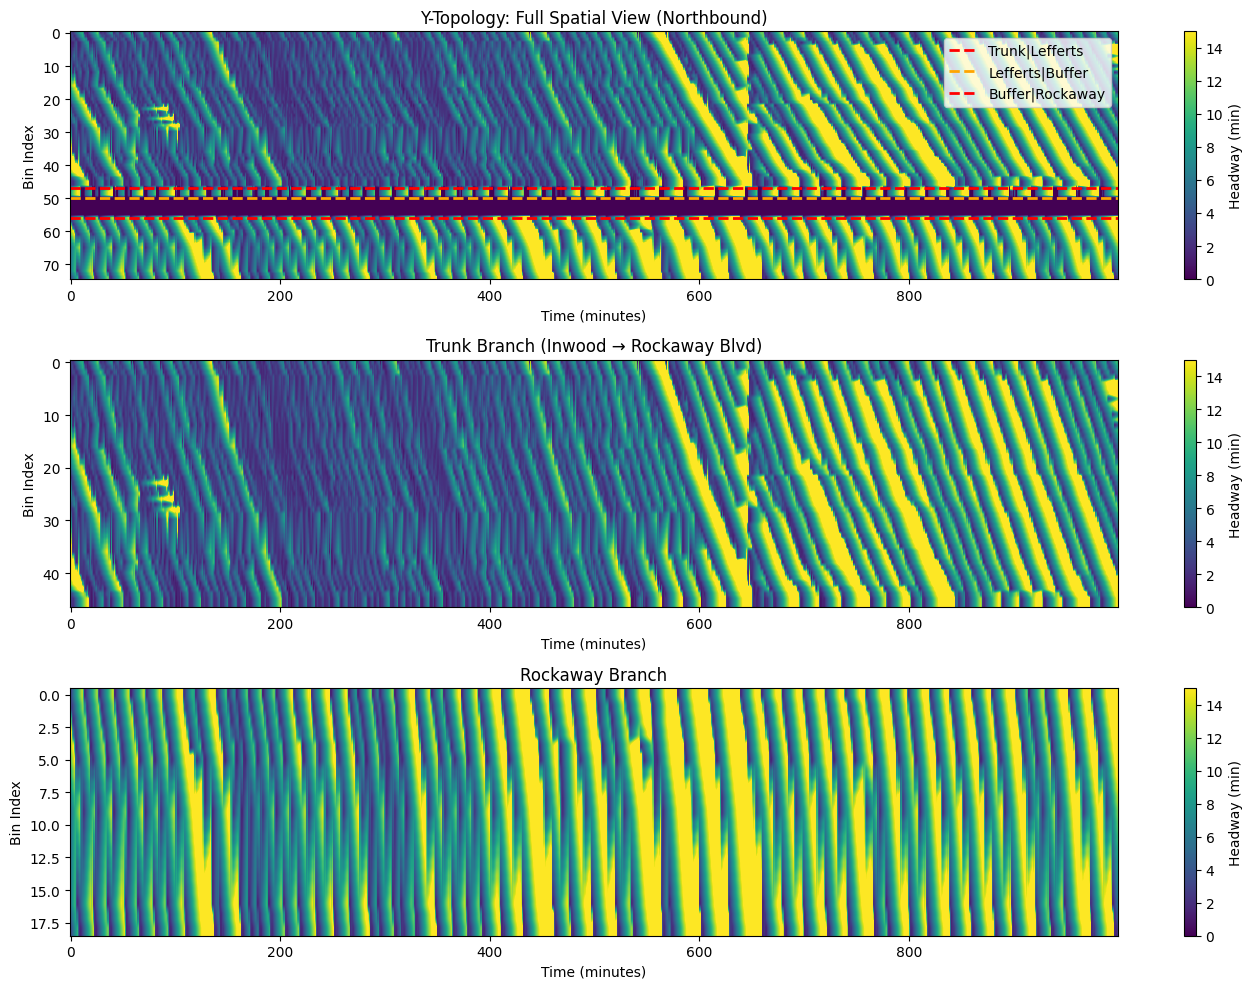

Saved visualization to ../images/y_topology_visualization.png


In [15]:
# 14. Visualization: Branch Structure

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Sample time window
t_start, t_len = 50000, 1000
sample_dir = 0  # Northbound

# Full view
ax1 = axes[0]
data_full = headway_out[t_start:t_start+t_len, :, sample_dir, 0].T
im1 = ax1.imshow(data_full, aspect='auto', cmap='viridis', vmin=0, vmax=15)
ax1.axhline(NUM_TRUNK, color='red', linestyle='--', linewidth=2, label='Trunk|Lefferts')
ax1.axhline(NUM_TRUNK + NUM_LEFFERTS, color='orange', linestyle='--', linewidth=2, label='Lefferts|Buffer')
ax1.axhline(NUM_TRUNK + NUM_LEFFERTS + NUM_BUFFER, color='red', linestyle='--', linewidth=2, label='Buffer|Rockaway')
ax1.set_title('Y-Topology: Full Spatial View (Northbound)')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Bin Index')
ax1.legend(loc='upper right')
plt.colorbar(im1, ax=ax1, label='Headway (min)')

# Trunk only
ax2 = axes[1]
data_trunk = headway_out[t_start:t_start+t_len, :NUM_TRUNK, sample_dir, 0].T
im2 = ax2.imshow(data_trunk, aspect='auto', cmap='viridis', vmin=0, vmax=15)
ax2.set_title('Trunk Branch (Inwood → Rockaway Blvd)')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Bin Index')
plt.colorbar(im2, ax=ax2, label='Headway (min)')

# Rockaway only
ax3 = axes[2]
rockaway_start = NUM_TRUNK + NUM_LEFFERTS + NUM_BUFFER
data_rockaway = headway_out[t_start:t_start+t_len, rockaway_start:, sample_dir, 0].T
im3 = ax3.imshow(data_rockaway, aspect='auto', cmap='viridis', vmin=0, vmax=15)
ax3.set_title('Rockaway Branch')
ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('Bin Index')
plt.colorbar(im3, ax=ax3, label='Headway (min)')

plt.tight_layout()
plt.savefig('../images/y_topology_visualization.png', dpi=150)
plt.show()

print("Saved visualization to ../images/y_topology_visualization.png")